In [1]:
import pandas
import numpy
from RexR import *
import _helpers
Rocket = RexR(datalocation = '_data/genomic_data/data.pkl', seed = 3123, debug = False, write_out=True) # '_data/genomic_data/data.pkl'
Rocket.load_probeset_data();

++++++++++++++++++++++++++++++ Firing up RexR! ++++++++++++++++++++++++++++++


In [2]:
import functions.rvm as RVM

In [3]:
from math import*
#from scipy.dspatial.distance import cosine
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cdist
from decimal import Decimal
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from time import time
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from itertools import cycle

In [4]:
TransPosed = Rocket.DATA_all_samples.T # all microarrays, may be multiple per patient versus all probesets, may be multiple per genome
Normal = Rocket.DATA_all_samples
AllNormal = Rocket.DATA_merged
#probeset_weights = Rocket.get_probeset_weights(method = )

In [5]:
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [6]:
X,y =_helpers._get_matrix(AllNormal, features = 'genomic', target = 'Treatment risk group in ALL10') 
linDA_transformed = LDA(solver='svd',shrinkage=None,priors=None,
                       n_components=2,store_covariance=False,tol=0.0001).fit(X,y).transform(X)

c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [8]:
latDA_transformed = LatentDirichletAllocation(n_components=10, 
                                               doc_topic_prior=None, 
                                               topic_word_prior=None, 
                                               learning_method=None, 
                                               learning_decay=0.7, 
                                               learning_offset=10.0, 
                                               max_iter=10, 
                                               batch_size=128, 
                                               evaluate_every=-1, 
                                               total_samples=1000000.0, 
                                               perp_tol=0.1, 
                                               mean_change_tol=0.001, 
                                               max_doc_update_iter=100, 
                                               n_jobs=1, 
                                               verbose=0, 
                                               random_state=None, 
                                               n_topics=None).fit(X,y).transform(X)

TypeError: __init__() got an unexpected keyword argument 'n_components'

In [5]:
# l-2 norm of rotation vectors
    # reduce to 3 dimensions
    #########################
def dim_reduction(x, reduction_type = 'PCA', dims = 3):
    # PCA/SVD/SOM/t-SNE/autoencoder
    
def rotation_norm(x, y, norm):   
    rot_vector = numpy.cross(a = x, b = y)
    norm_of_rotation = numpy.linalg.norm(rot_vector, ord = norm)
    return norm_of_rotation

reduced = dim_reduction(Transposed, dims = 3)
rotation_norm(reduced['9827_corr2.CEL'], reduced['9928_corr2.CEL'], 2)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [117]:
VarList = TransPosed.keys()
output = pandas.DataFrame()
count = 0
i = 0
j = 0
lim = len(VarList) 
inflation = 1
start = time()
for var_x in VarList:
    row = []
    j = 0
    for var_y in VarList:
        #sim_value = (minkowski_distance(TransPosed[var_x], TransPosed[var_y], 1))**inflation
        sim_value = minkowski(u = TransPosed[var_x], v = TransPosed[var_y], p =1)
        row.append(sim_value)        
        j = j + 1
        if(j>lim): break
    i = i + 1
    if(i>lim): break
    count = count + 1
    #print(" Processed similarity for:", var_x, len(VarList)-count, " more to go")
    row_ts = pandas.Series(row)
    row_ts.name = var_x
    output = output.append(row_ts)
print("runtime is", time()-start)
output.columns= VarList[:lim+1]
output[:5]

KeyboardInterrupt: 

# Patient clustering

In [22]:
# get patient similarity
#########################


def patient_similarity(patient_matrix, sim_type = 'cosine', minkowski_dim = None, normalised = True, inflation = 1):
    ''' Function to get similarity measures between patients  
        Variables:
            patient_matrix : dataframe with patient 1..N as columns and genome expressions 1..M as rows.
            sim_type : type of similarity measure
                values : 'cosine', 'manhattan', 'euclidian', 'minkowski', 'kendall', 'spearman', 'pearson',
                ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘dice’,‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, 
                ‘matching’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’
            minkowski_dim : dimensionality of minkowski space
                values : 3,4...inf (1= is manhattan, 2=euclidian)
            normalised : boolean
        output : 
            similarity matrix (DataFrame)       
    '''
    
    if len(patient_matrix<1000): 
        if (sim_type in ['cosine', 'manhattan', 'euclidian', 'minkowski', 'braycurtis', 'canberra', 'chebyshev', 'dice','hamming', 'jaccard', 'kulsinski', 'mahalanobis', 
                    'matching', 'rogerstanimoto', 'russellrao', 'seuclidean', '‘sokalmichener', 'sokalsneath']):
            A = numpy.array(patient_matrix)
        else:
            A = None
        VarList = patient_matrix.T.keys()
        if(sim_type == 'cosine'):        
            similarities = cdist(A, A, metric = 'cosine')
            patient_similarity = pandas.DataFrame(similarities, index = VarList, columns = VarList)
        elif(sim_type == 'manhattan'):
            similarities = cdist(A, A, metric = 'cityblock')
            patient_similarity = pandas.DataFrame(similarities, index = VarList, columns = VarList)        
        elif(sim_type == 'euclidian'):
            similarities = cdist(A, A, metric = 'euclidean')
            patient_similarity = pandas.DataFrame(similarities, index = VarList, columns = VarList)
        elif(sim_type == 'minkowski'):
            if (minkowski_dim == None):
                print("No Minkowski dimension given! Assuming minkowski dim is 3")
                minkowski_dim = 3
            similarities = cdist(A, A, metric = 'minkowski', p = minkowski_dim)
            patient_similarity = pandas.DataFrame(similarities, index = VarList, columns = VarList)       
        elif(sim_type in ['kendall', 'spearman', 'pearson']):
            patient_similarity = 1-patient_matrix.T.astype('float64').corr(method = sim_type)    
        elif(sim_type in ['braycurtis', 'canberra', 'chebyshev', 'dice','hamming', 'jaccard', 'kulsinski', 'mahalanobis', 
                    'matching', 'rogerstanimoto', 'russellrao', 'seuclidean', '‘sokalmichener', 'sokalsneath']):
            similarities = cdist(A, A, metric = sim_type)
            patient_similarity = pandas.DataFrame(similarities, index = VarList, columns = VarList)       
        ###
        if inflation > 1:
            patient_similarity = patient_similarity**inflation
        ###                                                               
        if normalised == True: # ! IMPROVE, not memory efficient
            patient_similarity = (patient_similarity - min(patient_similarity.min()))/(max(patient_similarity.max())-min(patient_similarity.min()))

        patient_similarity = 1 - patient_similarity
    else:
        raise ValueError('More than 1000 samples not supported at this moment')
    ###
    return patient_similarity

In [23]:
patient_sim = patient_similarity(Normal, sim_type = 'cosine', normalised = True, inflation = 2, minkowski_dim=1)
##### apply Markov clustering
#######################
# non-distributed, non-sparse version, only for small-sized problems (N is order 1000)
e = 2
r = 2 
epsilon = 1e-7
convergence = 0.001
num_iter = 12
Orientation = 'col' # columnwise or rowwise

# add loop
def add_loop(df_matrix, value=0): 
    for i in df_matrix.index:
        df_matrix.loc[i, i] = value
    return df_matrix
patient_sim = add_loop(patient_sim, 1)
patient_sim = patient_sim - epsilon

def normalise(sim, type = 'col'):
    if(type == 'col'):
        # column normalisation
        for variable in sim.keys():
            col_vec = sim[variable]
            sum_val = sum([p for p in col_vec])
            sim[variable] = sim[variable]/sum_val
    elif (type == 'row'):
        # row normalisation
        for variable in sim.keys():
            row_vec = sim.loc[variable, :]
            sum_val = sum([p for p in row_vec])
            sim.loc[variable,:] = sim.loc[variable,:]/sum_val
    return sim

# step E: expansion, get the nth power of the matrix
def expansion(sim):
    X = numpy.array(sim)
    VarList = sim.keys()
    if e == 1:
        return sim
    elif e > 1:        
        return pandas.DataFrame(numpy.linalg.matrix_power(X, e), index = VarList, columns = VarList)
     
# step I: inflation, per column raise by rth power and column normalise
def inflation(sim, type = 'col'):    
    if type == 'col':
        Axis = 0
    elif type == 'row':
        Axis = 1
    return sim.apply(lambda x: x**r/sum(x**r), axis = Axis)

# remove weak connections, values < epsilon
def clean(sim):
    return sim.applymap(lambda x:0 if x<epsilon else x)
    
def difference(old, new):
    # relative zeroes over entire array
    #return (new.apply(lambda x: numpy.ceil(x-epsilon)) - old.apply(lambda x: numpy.ceil(x-epsilon))).sum().sum()/len(old)**2    
    return abs(new - old).sum().sum()/len(old)**2    

#patient_sim = normalise(patient_sim, type = Orientation)
_sim_a = patient_sim
for i in range(0,num_iter):
    # repeat E and I until convergence, the row-wise elements form the clusters.
    _sim_b = clean(inflation(expansion(_sim_a), type = Orientation))
    #if ((difference(_sim_a, _sim_b)) < convergence) & (i>0):
    #    print(difference(_sim_a, _sim_b))
    #    print("CONVERGED after ", i, " iterations")
    #    break;
    _sim_a = _sim_b

result_mcl = clean(_sim_b)
result_mcl.loc[result_mcl.loc['9827_corr2.CEL',:]>epsilon, '9827_corr2.CEL']
# fetch clusters
#############



Series([], Name: 9827_corr2.CEL, dtype: float64)

In [102]:
patient_sim = patient_similarity(Normal, sim_type = 'euclidian', normalised = True, inflation=1, minkowski_dim=1)
##### apply Affinity Propagation
#######################
X = numpy.array(patient_sim)
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
cluster_labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
print("Cluster centers:",patient_sim.keys()[cluster_centers_indices].values)
print(af.labels_)

Cluster centers: ['1509.CEL' '8639.CEL' '5515.CEL' '6278.CEL']
[1 1 1 3 3 2 3 3 2 3 3 2 2 3 3 3 3 2 3 3 2 3 3 3 3 3 2 2 3 2 2 2 3 2 2 2 2
 2 2 3 2 3 3 1 2 2 3 3 3 2 2 2 2 1 1 2 2 3 3 2 2 3 1 3 2 2 2 2 2 2 1 2 0 2
 2 2 3 2 2 3 2 0 1 1 1 0 2 1 0 1 0 0 1 1 2 1 1 1 1 1 1 0 0 0 1 1 1 2 1 0 0
 1 0 1 1 1 1 1 0 1 0 1 1 2 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 2 3 2 1 3 1
 1 1 0 0 0 1 1 1 1 0 2 1 0 1 0 2 2 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 2 3 2 2 2 2 2 2 3 3 3 2 2 2 1 2 2 2
 3 2 2 2 2 2 3 2 3 3 2 2 3 3 2 0 2 2 2 2 3 2 2 2 2 1 3 2 2 3 3 3 3 2 3 3 2
 3 2 2 3 2 3 3 2 2 3 3 2 3 2 3 2 3 3 1 2 3 2 3 2 1 2 3 3 3 3 3 2 2 2 3 2 3
 3 3 2 2 2 2 3 3 1 2 3 3 3 1 3]


In [116]:
AggResults[AggResults['FU_RFS'].apply(lambda x: isnan(x) is False)].groupby(['Treatment risk group in ALL10', 'cluster_ap']).agg({'FU_RFS': numpy.mean })

,FU_RFS


In [117]:
AggResults[AggResults['FU_RFS'].apply(lambda x: isnan(x) is False)]['FU_RFS']

1       75.000000
2       64.000000
3       64.000000
4       72.000000
5       31.000000
6      183.000000
7      141.000000
8       67.000000
9       86.000000
10       2.000000
11     139.000000
12     111.000000
13     114.000000
14      14.000000
15       9.000000
16      19.000000
17      62.000000
18      63.000000
19      13.000000
20       9.000000
21      83.000000
22     132.000000
23      12.000000
24      87.000000
25     136.000000
26       8.000000
27       8.000000
28      74.000000
29      74.000000
30      37.000000
          ...    
101      7.000000
102    106.849315
103     94.093151
104     37.972603
105     67.594521
106     78.115068
107     61.512329
108     11.802740
109     11.704110
110      9.000000
111      9.000000
112     99.682192
113     19.002740
114     19.002740
115      0.821918
116     48.427397
117     55.232877
118     13.446575
119     85.216438
120     63.090411
121     95.572603
122     83.605479
123     82.290411
124     79.167123
125     50

In [115]:
AggResults = Rocket.DATA_merged
AggResults = _helpers._preprocess(AggResults)
AggResults = _helpers._group_patients(AggResults, method = 'mean')
AggResults['cluster_ap'] = cluster_labels
AggResults['FU_RFS'] = pandas.to_numeric(AggResults['FU_RFS'])
#AggResults.groupby(['Treatment risk group in ALL10', 'cluster_ap']).agg({'Microarray file': pandas.Series.nunique})
AggResults[AggResults['FU_RFS'].apply(lambda x: isnan(x) is False)].groupby(['Treatment risk group in ALL10', 'cluster_ap']).agg({'FU_RFS': numpy.mean })

c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,,FU_RFS
Treatment risk group in ALL10,cluster_ap,


Cluster centers: ['KGK_Tall_JL_7415.CEL' '2113.CEL' '8639.CEL']
[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 2 0
 0 0 0 0 2 0 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 1 2 2 0 2 2 1 2 2 1 1 1 2 2 1 2 2 2 2 2 2 2 2 0 2 2 0 2
 2 2 1 2 2 2 2 2 2 1 2 2 1 2 2 2 0 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 2 2]


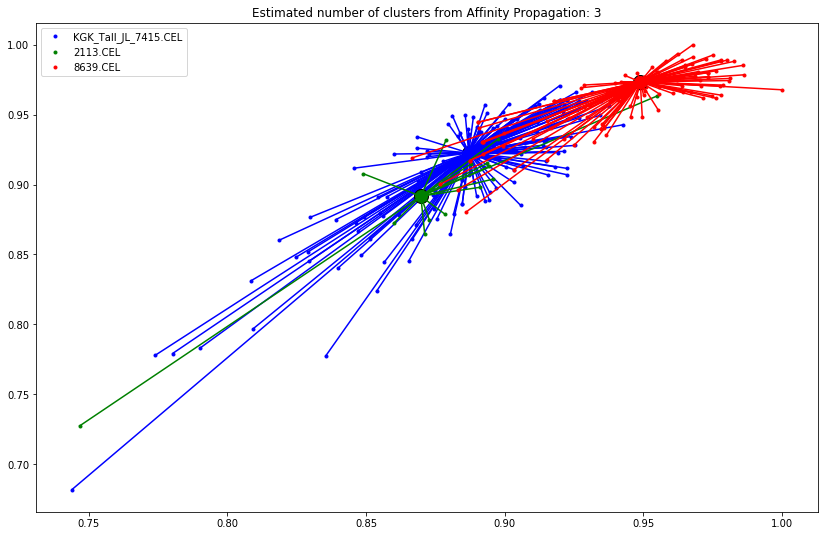

In [79]:
print("Cluster centers:",patient_sim.keys()[cluster_centers_indices].values)
print(cluster_labels)

plt.close('all')
plt.figure(figsize=(14,9))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = cluster_labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.', 
             label = patient_sim.keys()[cluster_centers_indices[k]])
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.legend()
        
plt.title('Estimated number of clusters from Affinity Propagation: %d' % n_clusters_)
plt.show()

In [19]:
##### CREATE graph from similarity matrix
##################
# nodes
VarList = TransPosed.keys()
nodes = []
node_index = 0
for patient_name in VarList:
    nodes.append((node_index, {'name': patient_name}))
    node_index = node_index + 1

edges = []
# edges
patient_sim = patient_similarity(Normal, sim_type = 'pearson', normalised = True, inflation=2)
node_index_x = 0
node_index_y = 0
for patient_name_x in VarList:
    for patient_name_y in VarList:        
        edges.append((node_index_x, node_index_y, patient_sim.iloc[node_index_x, node_index_y]))
        node_index_y = node_index_y + 1
    node_index_x = node_index_x + 1
    node_index_y = 0

In [20]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges, weight = 'weight')

c:\users\bramva~1\envs\worken~1\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
c:\users\bramva~1\envs\worken~1\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
c:\users\bramva~1\envs\worken~1\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\bramva~1\envs\worken~1\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

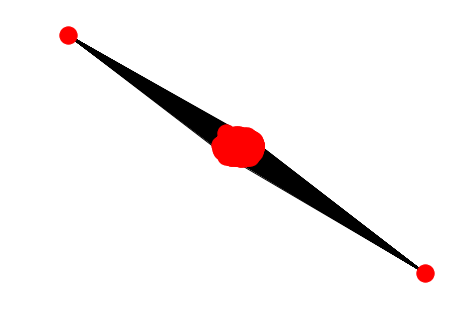

In [23]:
##### apply Spring-force
#######################
pos = nx.spring_layout(G, k = None, dim = 3, scale = 1.0)
nx.draw_spring(G, k = 30, dim = 2, scale = 1.0, iterations =1500)
plt.show()

In [ ]:
##### APPLY community detector
# maximize betweenness and modularity
##################################


In [12]:
##### LOAD IN DATA
###################
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
# 

In [7]:
df = _helpers._preprocess(Rocket.DATA_merged) 
df = _helpers._group_patients(df, method = 'mean')

In [8]:
x,y =_helpers._get_matrix(df, features = 'genomic', target = 'Treatment risk group in ALL10')

In [53]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
forest.fit(x, y)
importances = forest.feature_importances_
indices = np.argsort(numpy.abs(importances))[::-1]


In [54]:
gene_columns = Rocket.DATA_merged.columns[21:].values
for f in range(x.shape[1]):
    print("%d. feature %d (%f) probeset (%str)" % (f + 1, indices[f], importances[indices[f]], gene_columns[indices[f]]))

1. feature 34870 (0.003053) probeset (225613_attr)
2. feature 41368 (0.002892) probeset (232114_attr)
3. feature 9297 (0.002842) probeset (1569566_attr)
4. feature 33024 (0.002633) probeset (223748_attr)
5. feature 32296 (0.002490) probeset (223017_attr)
6. feature 23542 (0.002446) probeset (214243_s_attr)
7. feature 20806 (0.002391) probeset (211478_s_attr)
8. feature 45541 (0.002388) probeset (236292_attr)
9. feature 11703 (0.002294) probeset (202255_s_attr)
10. feature 25077 (0.002226) probeset (215784_attr)
11. feature 20874 (0.002167) probeset (211549_s_attr)
12. feature 37921 (0.001970) probeset (228667_attr)
13. feature 10463 (0.001969) probeset (201015_s_attr)
14. feature 14987 (0.001963) probeset (205540_s_attr)
15. feature 34520 (0.001939) probeset (225263_attr)
16. feature 5324 (0.001854) probeset (1560396_attr)
17. feature 7216 (0.001819) probeset (1563473_attr)
18. feature 15581 (0.001814) probeset (206135_attr)
19. feature 39780 (0.001739) probeset (230526_attr)
20. featu

2134. feature 790 (0.000156) probeset (1553356_attr)
2135. feature 3851 (0.000156) probeset (1557737_s_attr)
2136. feature 2083 (0.000156) probeset (1555127_attr)
2137. feature 35446 (0.000155) probeset (226190_attr)
2138. feature 49566 (0.000155) probeset (240317_attr)
2139. feature 10455 (0.000155) probeset (201007_attr)
2140. feature 36845 (0.000155) probeset (227591_attr)
2141. feature 17937 (0.000155) probeset (208519_x_attr)
2142. feature 23519 (0.000155) probeset (214220_s_attr)
2143. feature 36430 (0.000154) probeset (227175_attr)
2144. feature 3813 (0.000153) probeset (1557684_attr)
2145. feature 48001 (0.000153) probeset (238752_attr)
2146. feature 10820 (0.000153) probeset (201372_s_attr)
2147. feature 19517 (0.000152) probeset (210113_s_attr)
2148. feature 45482 (0.000152) probeset (236233_attr)
2149. feature 1297 (0.000152) probeset (1554053_attr)
2150. feature 20878 (0.000152) probeset (211553_x_attr)
2151. feature 32826 (0.000151) probeset (223550_s_attr)
2152. feature 1

4565. feature 16878 (0.000000) probeset (207436_x_attr)
4566. feature 16887 (0.000000) probeset (207445_s_attr)
4567. feature 16889 (0.000000) probeset (207447_s_attr)
4568. feature 25573 (0.000000) probeset (216281_attr)
4569. feature 25575 (0.000000) probeset (216283_s_attr)
4570. feature 16902 (0.000000) probeset (207460_attr)
4571. feature 16901 (0.000000) probeset (207459_x_attr)
4572. feature 16665 (0.000000) probeset (207220_attr)
4573. feature 25574 (0.000000) probeset (216282_x_attr)
4574. feature 16900 (0.000000) probeset (207458_attr)
4575. feature 16899 (0.000000) probeset (207457_s_attr)
4576. feature 16898 (0.000000) probeset (207456_attr)
4577. feature 16896 (0.000000) probeset (207454_attr)
4578. feature 16890 (0.000000) probeset (207448_attr)
4579. feature 16895 (0.000000) probeset (207453_s_attr)
4580. feature 25576 (0.000000) probeset (216284_attr)
4581. feature 16894 (0.000000) probeset (207452_s_attr)
4582. feature 16893 (0.000000) probeset (207451_attr)
4583. feat

7234. feature 14370 (0.000000) probeset (204923_attr)
7235. feature 14369 (0.000000) probeset (204922_attr)
7236. feature 14368 (0.000000) probeset (204921_attr)
7237. feature 14367 (0.000000) probeset (204920_attr)
7238. feature 14366 (0.000000) probeset (204919_attr)
7239. feature 14365 (0.000000) probeset (204918_s_attr)
7240. feature 14364 (0.000000) probeset (204917_s_attr)
7241. feature 14363 (0.000000) probeset (204916_attr)
7242. feature 14362 (0.000000) probeset (204915_s_attr)
7243. feature 26301 (0.000000) probeset (217011_attr)
7244. feature 26302 (0.000000) probeset (217012_attr)
7245. feature 14377 (0.000000) probeset (204930_s_attr)
7246. feature 26296 (0.000000) probeset (217006_x_attr)
7247. feature 14378 (0.000000) probeset (204931_attr)
7248. feature 14386 (0.000000) probeset (204939_s_attr)
7249. feature 14393 (0.000000) probeset (204946_s_attr)
7250. feature 26291 (0.000000) probeset (217001_x_attr)
7251. feature 14392 (0.000000) probeset (204945_attr)
7252. featur

9805. feature 22282 (0.000000) probeset (212979_s_attr)
9806. feature 22281 (0.000000) probeset (212978_attr)
9807. feature 22280 (0.000000) probeset (212977_attr)
9808. feature 22279 (0.000000) probeset (212976_attr)
9809. feature 22278 (0.000000) probeset (212975_attr)
9810. feature 22277 (0.000000) probeset (212974_attr)
9811. feature 24037 (0.000000) probeset (214741_attr)
9812. feature 22276 (0.000000) probeset (212973_attr)
9813. feature 22294 (0.000000) probeset (212991_attr)
9814. feature 22295 (0.000000) probeset (212992_attr)
9815. feature 22296 (0.000000) probeset (212993_attr)
9816. feature 22306 (0.000000) probeset (213003_s_attr)
9817. feature 24032 (0.000000) probeset (214736_s_attr)
9818. feature 22311 (0.000000) probeset (213008_attr)
9819. feature 24033 (0.000000) probeset (214737_x_attr)
9820. feature 22310 (0.000000) probeset (213007_attr)
9821. feature 22309 (0.000000) probeset (213006_attr)
9822. feature 22308 (0.000000) probeset (213005_s_attr)
9823. feature 2403

12878. feature 24737 (0.000000) probeset (215443_attr)
12879. feature 19659 (0.000000) probeset (210259_s_attr)
12880. feature 19658 (0.000000) probeset (210258_attr)
12881. feature 19657 (0.000000) probeset (210257_x_attr)
12882. feature 19656 (0.000000) probeset (210256_s_attr)
12883. feature 24734 (0.000000) probeset (215440_s_attr)
12884. feature 24733 (0.000000) probeset (215439_x_attr)
12885. feature 24732 (0.000000) probeset (215438_x_attr)
12886. feature 19685 (0.000000) probeset (210285_x_attr)
12887. feature 24729 (0.000000) probeset (215435_attr)
12888. feature 24730 (0.000000) probeset (215436_attr)
12889. feature 19690 (0.000000) probeset (210290_attr)
12890. feature 19689 (0.000000) probeset (210289_attr)
12891. feature 19688 (0.000000) probeset (210288_attr)
12892. feature 19687 (0.000000) probeset (210287_s_attr)
12893. feature 19686 (0.000000) probeset (210286_s_attr)
12894. feature 24731 (0.000000) probeset (215437_x_attr)
12895. feature 19684 (0.000000) probeset (210

15819. feature 4961 (0.000000) probeset (1559713_attr)
15820. feature 4949 (0.000000) probeset (1559695_a_attr)
15821. feature 4960 (0.000000) probeset (1559712_attr)
15822. feature 4959 (0.000000) probeset (1559711_attr)
15823. feature 4958 (0.000000) probeset (1559709_attr)
15824. feature 4957 (0.000000) probeset (1559707_attr)
15825. feature 4956 (0.000000) probeset (1559706_attr)
15826. feature 4955 (0.000000) probeset (1559705_s_attr)
15827. feature 4954 (0.000000) probeset (1559702_attr)
15828. feature 4953 (0.000000) probeset (1559701_s_attr)
15829. feature 4952 (0.000000) probeset (1559699_attr)
15830. feature 4951 (0.000000) probeset (1559697_a_attr)
15831. feature 4919 (0.000000) probeset (1559652_attr)
15832. feature 4918 (0.000000) probeset (1559651_attr)
15833. feature 4917 (0.000000) probeset (1559650_attr)
15834. feature 4874 (0.000000) probeset (1559583_attr)
15835. feature 4884 (0.000000) probeset (1559597_attr)
15836. feature 4883 (0.000000) probeset (1559595_attr)
15

18758. feature 909 (0.000000) probeset (1553508_attr)
18759. feature 987 (0.000000) probeset (1553604_attr)
18760. feature 988 (0.000000) probeset (1553605_a_attr)
18761. feature 989 (0.000000) probeset (1553607_attr)
18762. feature 1056 (0.000000) probeset (1553703_attr)
18763. feature 1067 (0.000000) probeset (1553718_attr)
18764. feature 1065 (0.000000) probeset (1553715_s_attr)
18765. feature 1064 (0.000000) probeset (1553713_a_attr)
18766. feature 1063 (0.000000) probeset (1553711_a_attr)
18767. feature 1062 (0.000000) probeset (1553710_attr)
18768. feature 1061 (0.000000) probeset (1553709_a_attr)
18769. feature 1060 (0.000000) probeset (1553708_attr)
18770. feature 1059 (0.000000) probeset (1553706_attr)
18771. feature 1058 (0.000000) probeset (1553705_a_attr)
18772. feature 1057 (0.000000) probeset (1553704_x_attr)
18773. feature 1055 (0.000000) probeset (1553702_attr)
18774. feature 1042 (0.000000) probeset (1553685_s_attr)
18775. feature 1054 (0.000000) probeset (1553701_a_at

21813. feature 11716 (0.000000) probeset (202268_s_attr)
21814. feature 11715 (0.000000) probeset (202267_attr)
21815. feature 11714 (0.000000) probeset (202266_attr)
21816. feature 11738 (0.000000) probeset (202290_attr)
21817. feature 11739 (0.000000) probeset (202291_s_attr)
21818. feature 11740 (0.000000) probeset (202292_x_attr)
21819. feature 11742 (0.000000) probeset (202294_attr)
21820. feature 11763 (0.000000) probeset (202315_s_attr)
21821. feature 11762 (0.000000) probeset (202314_attr)
21822. feature 11761 (0.000000) probeset (202313_attr)
21823. feature 11760 (0.000000) probeset (202312_s_attr)
21824. feature 11759 (0.000000) probeset (202311_s_attr)
21825. feature 11758 (0.000000) probeset (202310_s_attr)
21826. feature 11757 (0.000000) probeset (202309_attr)
21827. feature 11756 (0.000000) probeset (202308_attr)
21828. feature 11755 (0.000000) probeset (202307_s_attr)
21829. feature 11754 (0.000000) probeset (202306_attr)
21830. feature 11753 (0.000000) probeset (202305_

24758. feature 13271 (0.000000) probeset (203824_attr)
24759. feature 13260 (0.000000) probeset (203813_s_attr)
24760. feature 13270 (0.000000) probeset (203823_attr)
24761. feature 13269 (0.000000) probeset (203822_s_attr)
24762. feature 13268 (0.000000) probeset (203821_attr)
24763. feature 13267 (0.000000) probeset (203820_s_attr)
24764. feature 13266 (0.000000) probeset (203819_s_attr)
24765. feature 13265 (0.000000) probeset (203818_s_attr)
24766. feature 13264 (0.000000) probeset (203817_attr)
24767. feature 13263 (0.000000) probeset (203816_attr)
24768. feature 13262 (0.000000) probeset (203815_attr)
24769. feature 13261 (0.000000) probeset (203814_s_attr)
24770. feature 13232 (0.000000) probeset (203785_s_attr)
24771. feature 13231 (0.000000) probeset (203784_s_attr)
24772. feature 13230 (0.000000) probeset (203783_x_attr)
24773. feature 13188 (0.000000) probeset (203741_s_attr)
24774. feature 13200 (0.000000) probeset (203753_attr)
24775. feature 13199 (0.000000) probeset (203

27844. feature 9016 (0.000000) probeset (1569073_x_attr)
27845. feature 9015 (0.000000) probeset (1569072_s_attr)
27846. feature 9014 (0.000000) probeset (1569069_s_attr)
27847. feature 9013 (0.000000) probeset (1569067_attr)
27848. feature 9012 (0.000000) probeset (1569065_s_attr)
27849. feature 9011 (0.000000) probeset (1569064_attr)
27850. feature 9010 (0.000000) probeset (1569063_attr)
27851. feature 9009 (0.000000) probeset (1569062_s_attr)
27852. feature 8981 (0.000000) probeset (1569005_attr)
27853. feature 8979 (0.000000) probeset (1569003_attr)
27854. feature 8927 (0.000000) probeset (1568899_attr)
27855. feature 8939 (0.000000) probeset (1568916_attr)
27856. feature 8949 (0.000000) probeset (1568930_attr)
27857. feature 8948 (0.000000) probeset (1568929_attr)
27858. feature 8947 (0.000000) probeset (1568926_x_attr)
27859. feature 8946 (0.000000) probeset (1568925_attr)
27860. feature 8945 (0.000000) probeset (1568924_a_attr)
27861. feature 8944 (0.000000) probeset (1568923_at

30957. feature 46239 (0.000000) probeset (236990_attr)
30958. feature 46238 (0.000000) probeset (236989_attr)
30959. feature 46237 (0.000000) probeset (236988_x_attr)
30960. feature 46236 (0.000000) probeset (236987_attr)
30961. feature 46235 (0.000000) probeset (236986_attr)
30962. feature 46234 (0.000000) probeset (236985_attr)
30963. feature 46233 (0.000000) probeset (236984_attr)
30964. feature 46232 (0.000000) probeset (236983_attr)
30965. feature 46231 (0.000000) probeset (236982_attr)
30966. feature 46230 (0.000000) probeset (236981_attr)
30967. feature 46253 (0.000000) probeset (237004_attr)
30968. feature 46254 (0.000000) probeset (237005_attr)
30969. feature 46255 (0.000000) probeset (237006_attr)
30970. feature 46256 (0.000000) probeset (237007_attr)
30971. feature 46279 (0.000000) probeset (237030_attr)
30972. feature 46278 (0.000000) probeset (237029_attr)
30973. feature 46277 (0.000000) probeset (237028_attr)
30974. feature 46276 (0.000000) probeset (237027_attr)
30975. f

33798. feature 44069 (0.000000) probeset (234820_attr)
33799. feature 44091 (0.000000) probeset (234842_attr)
33800. feature 44093 (0.000000) probeset (234844_attr)
33801. feature 44015 (0.000000) probeset (234766_attr)
33802. feature 44106 (0.000000) probeset (234857_attr)
33803. feature 44116 (0.000000) probeset (234867_attr)
33804. feature 44115 (0.000000) probeset (234866_s_attr)
33805. feature 44114 (0.000000) probeset (234865_attr)
33806. feature 44113 (0.000000) probeset (234864_s_attr)
33807. feature 44112 (0.000000) probeset (234863_x_attr)
33808. feature 44111 (0.000000) probeset (234862_attr)
33809. feature 44110 (0.000000) probeset (234861_attr)
33810. feature 44109 (0.000000) probeset (234860_attr)
33811. feature 44108 (0.000000) probeset (234859_attr)
33812. feature 44107 (0.000000) probeset (234858_attr)
33813. feature 44105 (0.000000) probeset (234856_attr)
33814. feature 44094 (0.000000) probeset (234845_attr)
33815. feature 44104 (0.000000) probeset (234855_attr)
3381

36481. feature 51805 (0.000000) probeset (242556_attr)
36482. feature 51804 (0.000000) probeset (242555_attr)
36483. feature 51803 (0.000000) probeset (242554_attr)
36484. feature 51802 (0.000000) probeset (242553_attr)
36485. feature 51801 (0.000000) probeset (242552_x_attr)
36486. feature 51800 (0.000000) probeset (242551_attr)
36487. feature 51799 (0.000000) probeset (242550_attr)
36488. feature 51798 (0.000000) probeset (242549_attr)
36489. feature 51797 (0.000000) probeset (242548_x_attr)
36490. feature 51794 (0.000000) probeset (242545_attr)
36491. feature 51783 (0.000000) probeset (242534_attr)
36492. feature 51793 (0.000000) probeset (242544_x_attr)
36493. feature 51792 (0.000000) probeset (242543_attr)
36494. feature 51791 (0.000000) probeset (242542_attr)
36495. feature 51790 (0.000000) probeset (242541_attr)
36496. feature 51789 (0.000000) probeset (242540_attr)
36497. feature 51788 (0.000000) probeset (242539_attr)
36498. feature 51787 (0.000000) probeset (242538_attr)
3649

38776. feature 49305 (0.000000) probeset (240056_attr)
38777. feature 49304 (0.000000) probeset (240055_attr)
38778. feature 49303 (0.000000) probeset (240054_attr)
38779. feature 49302 (0.000000) probeset (240053_x_attr)
38780. feature 49301 (0.000000) probeset (240052_attr)
38781. feature 49299 (0.000000) probeset (240050_s_attr)
38782. feature 49339 (0.000000) probeset (240090_attr)
38783. feature 49298 (0.000000) probeset (240049_attr)
38784. feature 49296 (0.000000) probeset (240047_attr)
38785. feature 49295 (0.000000) probeset (240046_attr)
38786. feature 49294 (0.000000) probeset (240045_attr)
38787. feature 49293 (0.000000) probeset (240044_x_attr)
38788. feature 49292 (0.000000) probeset (240043_attr)
38789. feature 49290 (0.000000) probeset (240041_attr)
38790. feature 49289 (0.000000) probeset (240040_attr)
38791. feature 49288 (0.000000) probeset (240039_attr)
38792. feature 49286 (0.000000) probeset (240037_attr)
38793. feature 49311 (0.000000) probeset (240062_attr)
3879

41901. feature 30927 (0.000000) probeset (221646_s_attr)
41902. feature 30926 (0.000000) probeset (221645_s_attr)
41903. feature 30925 (0.000000) probeset (221644_s_attr)
41904. feature 30924 (0.000000) probeset (221643_s_attr)
41905. feature 30923 (0.000000) probeset (221642_attr)
41906. feature 30922 (0.000000) probeset (221641_s_attr)
41907. feature 31225 (0.000000) probeset (221945_attr)
41908. feature 31227 (0.000000) probeset (221947_attr)
41909. feature 30785 (0.000000) probeset (221502_attr)
41910. feature 31517 (0.000000) probeset (222238_s_attr)
41911. feature 31528 (0.000000) probeset (222249_attr)
41912. feature 31527 (0.000000) probeset (222248_s_attr)
41913. feature 31526 (0.000000) probeset (222247_attr)
41914. feature 31525 (0.000000) probeset (222246_attr)
41915. feature 31524 (0.000000) probeset (222245_s_attr)
41916. feature 31523 (0.000000) probeset (222244_s_attr)
41917. feature 31522 (0.000000) probeset (222243_s_attr)
41918. feature 31521 (0.000000) probeset (222

44758. feature 32233 (0.000000) probeset (222954_attr)
44759. feature 32232 (0.000000) probeset (222953_attr)
44760. feature 32231 (0.000000) probeset (222952_s_attr)
44761. feature 32230 (0.000000) probeset (222951_s_attr)
44762. feature 32229 (0.000000) probeset (222950_attr)
44763. feature 32228 (0.000000) probeset (222949_attr)
44764. feature 32227 (0.000000) probeset (222948_s_attr)
44765. feature 32249 (0.000000) probeset (222970_attr)
44766. feature 32250 (0.000000) probeset (222971_attr)
44767. feature 32251 (0.000000) probeset (222972_attr)
44768. feature 32252 (0.000000) probeset (222973_attr)
44769. feature 32276 (0.000000) probeset (222997_s_attr)
44770. feature 32275 (0.000000) probeset (222996_s_attr)
44771. feature 32274 (0.000000) probeset (222995_s_attr)
44772. feature 32273 (0.000000) probeset (222994_attr)
44773. feature 32272 (0.000000) probeset (222993_attr)
44774. feature 32270 (0.000000) probeset (222991_s_attr)
44775. feature 32269 (0.000000) probeset (222990_at

47961. feature 28602 (0.000000) probeset (219318_x_attr)
47962. feature 28627 (0.000000) probeset (219343_attr)
47963. feature 28626 (0.000000) probeset (219342_attr)
47964. feature 28625 (0.000000) probeset (219341_attr)
47965. feature 28622 (0.000000) probeset (219338_s_attr)
47966. feature 28621 (0.000000) probeset (219337_attr)
47967. feature 28620 (0.000000) probeset (219336_s_attr)
47968. feature 28619 (0.000000) probeset (219335_attr)
47969. feature 28618 (0.000000) probeset (219334_s_attr)
47970. feature 28617 (0.000000) probeset (219333_s_attr)
47971. feature 28616 (0.000000) probeset (219332_attr)
47972. feature 28615 (0.000000) probeset (219331_s_attr)
47973. feature 28614 (0.000000) probeset (219330_attr)
47974. feature 28613 (0.000000) probeset (219329_s_attr)
47975. feature 28612 (0.000000) probeset (219328_attr)
47976. feature 28609 (0.000000) probeset (219325_s_attr)
47977. feature 28608 (0.000000) probeset (219324_attr)
47978. feature 28607 (0.000000) probeset (219323_

50777. feature 38878 (0.000000) probeset (229624_attr)
50778. feature 38892 (0.000000) probeset (229638_attr)
50779. feature 38876 (0.000000) probeset (229622_attr)
50780. feature 38875 (0.000000) probeset (229621_x_attr)
50781. feature 38874 (0.000000) probeset (229620_attr)
50782. feature 38873 (0.000000) probeset (229619_attr)
50783. feature 38872 (0.000000) probeset (229618_attr)
50784. feature 38871 (0.000000) probeset (229617_x_attr)
50785. feature 38870 (0.000000) probeset (229616_s_attr)
50786. feature 38869 (0.000000) probeset (229615_attr)
50787. feature 38868 (0.000000) probeset (229614_attr)
50788. feature 38867 (0.000000) probeset (229613_attr)
50789. feature 38891 (0.000000) probeset (229637_attr)
50790. feature 38893 (0.000000) probeset (229639_s_attr)
50791. feature 38920 (0.000000) probeset (229666_s_attr)
50792. feature 38906 (0.000000) probeset (229652_s_attr)
50793. feature 38917 (0.000000) probeset (229663_attr)
50794. feature 38916 (0.000000) probeset (229662_attr

53830. feature 36731 (0.000000) probeset (227476_attr)
53831. feature 36754 (0.000000) probeset (227500_attr)
53832. feature 36753 (0.000000) probeset (227499_attr)
53833. feature 36752 (0.000000) probeset (227498_attr)
53834. feature 36751 (0.000000) probeset (227497_attr)
53835. feature 36750 (0.000000) probeset (227496_attr)
53836. feature 36749 (0.000000) probeset (227494_attr)
53837. feature 36748 (0.000000) probeset (227493_s_attr)
53838. feature 36747 (0.000000) probeset (227492_attr)
53839. feature 36746 (0.000000) probeset (227491_attr)
53840. feature 36743 (0.000000) probeset (227488_attr)
53841. feature 36742 (0.000000) probeset (227487_s_attr)
53842. feature 36741 (0.000000) probeset (227486_attr)
53843. feature 36740 (0.000000) probeset (227485_attr)
53844. feature 36739 (0.000000) probeset (227484_attr)
53845. feature 36738 (0.000000) probeset (227483_s_attr)
53846. feature 36737 (0.000000) probeset (227482_attr)
53847. feature 36736 (0.000000) probeset (227481_attr)
5384

In [55]:
# testing the RVM
model_rvm = RVM.rvm(x, y, noise = 0.05)
model_rvm.iterateUntilConvergence()
preds_rvm = numpy.dot(x, model_rvm.wInferred)

Initial alpha = [[ 0.0684359]]
   1 - L=-18.6918527 - Gamma= 1.9992237 (M=   2) - s=0.0500
   2 - L=-13.4410122 - Gamma= 2.9975337 (M=   3) - s=0.0500
   3 - L=-10.0365822 - Gamma= 3.9950049 (M=   4) - s=0.0500
   4 - L=-6.7305076 - Gamma= 4.9921205 (M=   5) - s=0.0500
   5 - L=-4.3055586 - Gamma= 5.9886301 (M=   6) - s=0.0500
   6 - L=-2.6091433 - Gamma= 6.9834294 (M=   7) - s=0.0500
   7 - L=-1.1053203 - Gamma= 7.9776633 (M=   8) - s=0.0500
   8 - L=-0.1502112 - Gamma= 8.9682509 (M=   9) - s=0.0500
   9 - L= 0.6371283 - Gamma= 9.9570653 (M=  10) - s=0.0500
  10 - L= 1.1069540 - Gamma=10.9396472 (M=  11) - s=0.0500
  11 - L= 1.4296612 - Gamma=11.9118714 (M=  12) - s=0.0500
  12 - L= 1.5963152 - Gamma=12.8680237 (M=  13) - s=0.0500
  13 - L= 1.7329606 - Gamma=13.8124501 (M=  14) - s=0.0500
  14 - L= 1.8394735 - Gamma=14.7419679 (M=  15) - s=0.0500
  15 - L= 1.9033161 - Gamma=15.6419766 (M=  16) - s=0.0500
  16 - L= 1.9456110 - Gamma=16.5087200 (M=  17) - s=0.0500
  17 - L= 1.9743057 - 

C:\Users\Bram van Es\DEV\RexR\functions\rvm.py:289: RuntimeWarning: invalid value encountered in log
  change = np.abs(np.log(newAlpha) - np.log(self.Alpha[j]))


 123 - L= 2.0177849 - Gamma=20.4736442 (M=  27) - s=0.0500
 124 - L= 2.0178295 - Gamma=20.4988433 (M=  27) - s=0.0500
 125 - L= 2.0178641 - Gamma=20.4994693 (M=  27) - s=0.0500
 126 - L= 2.0178916 - Gamma=20.5645206 (M=  28) - s=0.0500
 127 - L= 2.0179203 - Gamma=20.5216177 (M=  28) - s=0.0500
 128 - L= 2.0179521 - Gamma=20.4859317 (M=  28) - s=0.0500
 129 - L= 2.0179819 - Gamma=20.5552088 (M=  28) - s=0.0500
 130 - L= 2.0180025 - Gamma=20.5533730 (M=  28) - s=0.0500
 131 - L= 2.0180203 - Gamma=20.5378483 (M=  28) - s=0.0500
 132 - L= 2.0180428 - Gamma=20.5947739 (M=  29) - s=0.0500
 133 - L= 2.0180700 - Gamma=20.6385586 (M=  29) - s=0.0500
 134 - L= 2.0181011 - Gamma=20.5674775 (M=  29) - s=0.0500
 135 - L= 2.0181265 - Gamma=20.5606423 (M=  29) - s=0.0500
 136 - L= 2.0181447 - Gamma=20.6085010 (M=  29) - s=0.0500
 137 - L= 2.0181787 - Gamma=20.5577506 (M=  29) - s=0.0500
 138 - L= 2.0182158 - Gamma=20.6278913 (M=  29) - s=0.0500
 139 - L= 2.0182394 - Gamma=20.5838829 (M=  28) - s=0.05

In [58]:
preds_rvm

array([[  2.08252462e-02],
       [ -2.15517416e-02],
       [  2.19470351e-02],
       [  9.78732878e-01],
       [  9.86275557e-01],
       [  9.95655057e-01],
       [ -4.05289518e-03],
       [ -3.67386087e-03],
       [  1.00436995e+00],
       [  3.49952501e-02],
       [  9.87745999e-03],
       [ -1.86596670e-03],
       [ -2.67711486e-03],
       [ -1.70313638e-02],
       [  6.18110052e-03],
       [  9.81192492e-01],
       [ -9.63025596e-03],
       [  9.99798439e-01],
       [  7.25932322e-03],
       [  9.93246797e-01],
       [  6.66344593e-03],
       [ -1.23995165e-02],
       [ -6.04587897e-03],
       [  1.01574292e+00],
       [ -6.07561577e-03],
       [  1.32882903e-03],
       [  3.87707970e-03],
       [  1.57158160e-03],
       [ -1.23816231e-02],
       [  1.02085373e+00],
       [  9.95698483e-01],
       [  4.15960163e-04],
       [  1.62434964e-02],
       [  9.97638959e-01],
       [  9.97011449e-01],
       [  6.37314413e-03],
       [  1.45957658e-02],
 

In [5]:
preds, class_model = Rocket.classify_treatment(model_type = 'ensemble', 
                                              features = 'all', 
                                              grouping= 'mean', 
                                              n_splits = 10, 
                                              reduction = 'LDA',
                                              n_comp = 2000,
                                              re_normalise = True)

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
MODEL: GNB accuracy:  0.758620689655 +/-: 0.0410792140875
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

MODEL: SVM accuracy:  0.793103448276 +/-: 0.0104778891343
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.97      0.84        33
          1       0.93      0.56      0.70        25

avg / total       0.83      0.79      0.78        58

MODEL: LogisticRegression accuracy:  0.758620689655 +/-: 0.0410792140875
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

         

c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



MODEL: RandomForest accuracy:  0.706896551724 +/-: 0.0459458694298
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.72      0.79      0.75        33
          1       0.68      0.60      0.64        25

avg / total       0.70      0.71      0.70        58

MODEL: ExtraTrees accuracy:  0.775862068966 +/-: 0.0133910877074
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

MODEL: GBM accuracy:  0.637931034483 +/-: 0.039349413963
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.69      0.67      0.68        33
          1       0.58      0.60      0.59        25

avg / tot

In [19]:
preds = [pred_[1]for pred_ in preds]
#len(Rocket.DATA_merged[Rocket.DATA_merged["array-batch"].isin(["cohort 1", "cohort 2", "JB", "IA", "ALL-10"])])
Results = Rocket.DATA_merged_processed
Results['pred'] = preds
print(Results[:311][['labnr patient', 'pred', 'Treatment risk group in ALL10']])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [13]:
# get top genes
Rocket.get_top_genes(n = 100)

727.576388889
